In [20]:
#Includes necesarios
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# **Regresión Logistica**

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [21]:
X,y = get_train_set()
X = pr.init_dataset(X)

## Preprocesamiento 1: OHE

Primero vamos a entrenar nuestra regresion logisitca aplicando unicamente OHE a las columnas categoricas. Vamos a aplicar distintos tipos de *solver* apropiados para dataset que no tienen algun tipo de escalado en sus features:

In [22]:
pr.init_OHE(X)
X_ohe = pr.apply_OHE(X)

Partimos nuestro set en *train* y *validation*:

In [23]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*. Ahora bien, como nuestro dataset tiene una larga cantidad de muestras, es de esperar que la busqueda de hiperparametros sea extensa en tiempo. Tarda aproximadamente 10 minutos.

In [24]:
parameters = {
    'C': np.geomspace(1e-5,1e5, num=20),
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
    
}

clf = LogisticRegression()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.8999480599650689
Best params {'C': 0.5455594781168515, 'solver': 'newton-cg'}
------------------
Score in Validation: 0.901338382926477


Armo el modelo de regresion logistica con los hiperparametros calculados:

In [25]:
model_logreg = gscv.best_estimator_
model_logreg

LogisticRegression(C=0.5455594781168515, solver='newton-cg')

Predigo con el validation set:

In [26]:
logreg_predict = model_logreg.predict(X_validation)

**Metricas**

In [27]:
print(classification_report(y_validation, logreg_predict))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4945
           1       0.71      0.59      0.65      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.76      0.77      6513
weighted avg       0.84      0.84      0.84      6513



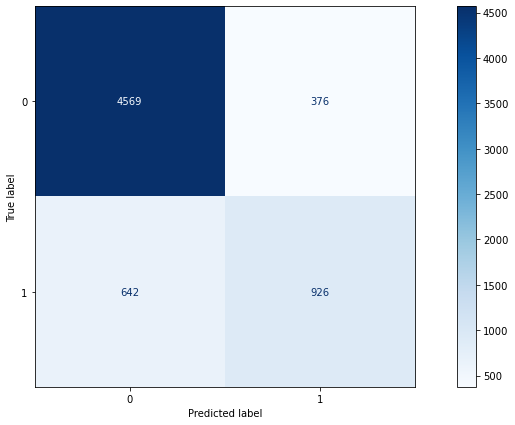

In [28]:
plot_cm(model_logreg, X_validation, y_validation)

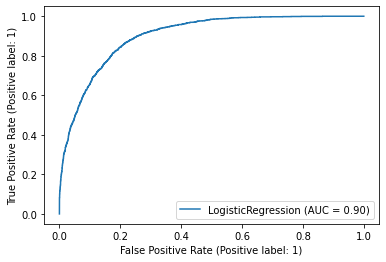

In [29]:
plot_roc_curve(model_logreg, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 1: OHE + Escalado

Ahora luego de haber aplicado OHE, realizaremos un escalado de nuestras columnas con MinMaxScaler.Este ultimo paso sera util ya que utilizaremos distintos tipos de *solver* apropiados para largos dataset. El rango del escalado sera (0,1) que viene predeterminado:

In [30]:
X_scale = pr.scale(X_ohe)

Partimos nuestro set en *train* y *validation*:

In [31]:
X_train, X_validation, y_train, y_validation = train_test_split(X_scale,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [32]:
parameters = {
    'C': np.geomspace(1e-5,1e5, num=20),
    'solver': ['sag', 'saga']
    
}

clf = LogisticRegression()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.8996388786018568
Best params {'C': 6.1584821106602545, 'solver': 'sag'}
------------------
Score in Validation: 0.9029458611048058


Armo el modelo de regresion logistica con los hiperparametros calculados:

In [33]:
model_logreg_p1 = gscv.best_estimator_
model_logreg_p1

LogisticRegression(C=6.1584821106602545, solver='sag')

Predigo con el validation set:

In [34]:
logreg_predict = model_logreg_p1.predict(X_validation)

**Metricas**

In [35]:
print(classification_report(y_validation, logreg_predict))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4945
           1       0.73      0.58      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.78      6513
weighted avg       0.84      0.85      0.84      6513



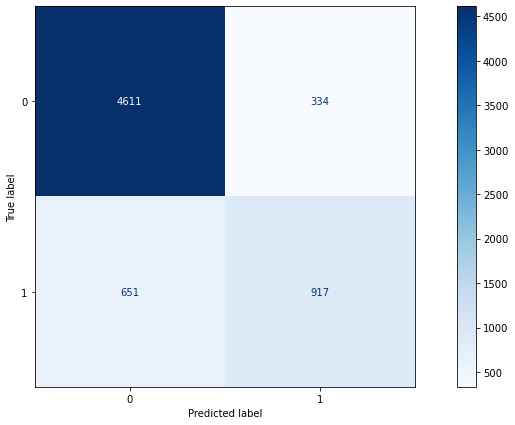

In [36]:
plot_cm(model_logreg_p1, X_validation, y_validation)

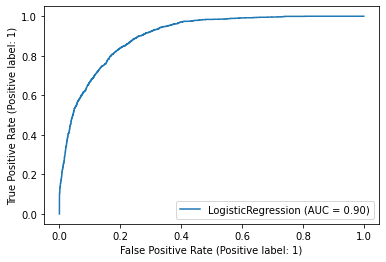

In [37]:
plot_roc_curve(model_logreg_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

# Predicción

In [42]:
ids, X_holdout = get_holdout_set()
X_holdout = pr.init_dataset(X_holdout)

In [43]:
pr.init_OHE(X)
X_holdout_ohe = pr.apply_OHE(X_holdout)
X_holdout_scale = pr.scale(X_holdout_ohe)

In [44]:
logreg_predict = model_logreg_p1.predict(X_holdout_scale)

In [45]:
create_prediction(ids,logreg_predict,file_name='regresion_logistica')

# Referencias

The “lbfgs” solver is used by default for its robustness. For large datasets the “saga” solver is usually faster. For large dataset, you may also consider using SGDClassifier with ‘log’ loss, which might be even faster but requires more tuning.

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

https://scikit-learn.org/stable/modules/preprocessing.html

https://youtu.be/0HDy6n3UD5M